## Class activation mapping visualization


In [32]:
# Import
import os

import torch
import torch.nn as nn
import torchvision.io
from torchvision.transforms import v2

from torch_api.dataset_utils.dataset_folder_utils import get_loader_from_dir
from torch_api.model_api import get_vgg, get_resnet, get_mobilenet
from utils.params import IMAGENET_MEAN, IMAGENET_STD

In [33]:
# Dataset
BRAIN_DS_DIR = os.path.abspath(".\\datasets\\brain_tumor")
TRAIN_DIR = os.path.join(BRAIN_DS_DIR, "train")
VAL_DIR = os.path.join(BRAIN_DS_DIR, "val")
TEST_DIR = os.path.join(BRAIN_DS_DIR, "test")

# Class weight
CLASS_WEIGHTS = torch.tensor([1, 0.544], dtype=torch.float32) # No class has 0.544 of Yes class

# Device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [34]:
# Check image's shape
for d in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    # Loop over classes
    for subdir in os.listdir(TRAIN_DIR):
        sub_path = os.path.join(TRAIN_DIR, subdir)
        # Loop over images in class dir
        for img in os.listdir(sub_path):
            img_path = os.path.join(sub_path, img)
            print(torchvision.io.read_image(img_path).shape)

torch.Size([1, 630, 630])
torch.Size([3, 201, 173])
torch.Size([3, 168, 300])
torch.Size([3, 183, 275])
torch.Size([3, 168, 300])
torch.Size([3, 197, 177])
torch.Size([3, 217, 232])
torch.Size([3, 231, 218])
torch.Size([3, 221, 228])
torch.Size([3, 200, 200])
torch.Size([3, 630, 630])
torch.Size([3, 259, 194])
torch.Size([3, 225, 225])
torch.Size([3, 243, 207])
torch.Size([3, 242, 208])
torch.Size([3, 214, 235])
torch.Size([3, 217, 232])
torch.Size([3, 252, 200])
torch.Size([3, 231, 218])
torch.Size([3, 251, 201])
torch.Size([3, 234, 215])
torch.Size([3, 225, 225])
torch.Size([3, 242, 208])
torch.Size([3, 252, 200])
torch.Size([3, 225, 225])
torch.Size([3, 213, 236])
torch.Size([3, 198, 150])
torch.Size([3, 225, 225])
torch.Size([3, 221, 228])
torch.Size([3, 225, 225])
torch.Size([3, 251, 201])
torch.Size([3, 225, 225])
torch.Size([3, 250, 201])
torch.Size([3, 225, 225])
torch.Size([3, 225, 225])
torch.Size([3, 168, 300])
torch.Size([3, 194, 259])
torch.Size([3, 442, 441])
torch.Size([

In [35]:
# Image Classification
H, W = 32, 32
img = torch.randint(0, 256, size=(3, H, W), dtype=torch.uint8)

train_transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=False),
    v2.RandomResizedCrop(size=(224, 224), antialias=True),

    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    v2.Grayscale(num_output_channels=3),
    
    # v2.RandomHorizontalFlip(p=0.5),
    # v2.ColorJitter(brightness = [0.9, 1.1]),
])

test_transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=False),
    v2.Resize(size=(224, 224), antialias=True),

    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    v2.Grayscale(num_output_channels=3),
])

In [36]:
# Get dataset
train_loader, val_loader, test_loader = get_loader_from_dir(
    base_dir=BRAIN_DS_DIR,
    train_transform=train_transforms,
    test_transform=test_transforms,
    collate_fn=None,
    batch_size=32
)

Classes: ['no', 'yes']
Sizes (train/valid/test): 193 20 40


In [37]:
# Get model
vgg_model = get_vgg(weight_name="default")
resnet_model = get_resnet(weight_name="default")
mobilenet_model = get_mobilenet(weight_name="default")

In [38]:
# Fix the last layers
vgg_model.classifier[-1] = nn.Linear(in_features=4096, out_features=2, bias=True)
resnet_model.fc = nn.Linear(in_features=2048, out_features=2, bias=True)
mobilenet_model.classifier[-1] = nn.Linear(in_features=1024, out_features=2, bias=True)

In [39]:
from torch_api.trainer_api.base import Trainer
from torch_api.regularizer_api import EarlyStopping

# Set things up
optimizer = torch.optim.Adam(resnet_model.parameters(), lr = 0.0005)
criterion = nn.CrossEntropyLoss(weight=CLASS_WEIGHTS).to(DEVICE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode = 'min',
    factor = 0.1,
    patience = 2
) # decrease after 2 times not improving (fluctuate 1 time)
early_stop = EarlyStopping(tolerance = 5)

# Get trainer for VGG
trainer = Trainer(
    model = resnet_model,
    train_loader = train_loader,
    val_loader = val_loader,
    test_loader = test_loader,
    optimizer = optimizer,
    criterion = criterion,
    scheduler = scheduler,
    early_stopping = early_stop,
    device = DEVICE,
)

Device of trainer is cuda


In [40]:
# Other blocks False Grad
for child in resnet_model.named_children():
    name, layer = child
    for param in layer.parameters():
        param.requires_grad = False

# Last conv layer
for param in resnet_model.layer4.parameters():
    param.requires_grad = True
for param in resnet_model.fc.parameters():
    param.requires_grad = True

In [41]:
trainer.train(epochs = 10)

EPOCH 0 Train loss: 0.6451963952609471, Val loss: 0.5043330788612366, Val acc: 0.8
EPOCH 1 Train loss: 0.593944081238338, Val loss: 0.7306978106498718, Val acc: 0.5
EPOCH 2 Train loss: 0.5453220648424966, Val loss: 0.4147712290287018, Val acc: 0.75
EPOCH 3 Train loss: 0.43829398708684103, Val loss: 0.41420629620552063, Val acc: 0.85
EPOCH 4 Train loss: 0.5701592905180795, Val loss: 0.4844987094402313, Val acc: 0.8
EPOCH 5 Train loss: 0.5482105910778046, Val loss: 0.46854716539382935, Val acc: 0.85
EPOCH 6 Train loss: 0.4159693099614482, Val loss: 0.40388089418411255, Val acc: 0.85
EPOCH 7 Train loss: 0.37381838474954876, Val loss: 0.4636150002479553, Val acc: 0.65
EPOCH 8 Train loss: 0.27087136038712095, Val loss: 0.5040549039840698, Val acc: 0.85
EPOCH 9 Train loss: 0.2886191728924002, Val loss: 0.34211140871047974, Val acc: 0.85


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def prepare_for_overlay(img: np.ndarray, target_dtype = np.uint8):
    """
    Converts image to a safe dtype for OpenCV addWeighted.
    - If already uint8, returns as-is.
    - If float32/float64 in [0,1], scales to [0,255].
    - Otherwise, casts safely to target_dtype.
    """
    if img.dtype == np.uint8:
        return img
    
    if np.issubdtype(img.dtype, np.floating):
        if img.max() <= 1.0:
            return (img * 255).astype(target_dtype)
        else:
            return img.astype(target_dtype)
    
    return img.astype(target_dtype)

def cam_heatmap_plot(
    original_img: np.ndarray, heatmap: np.ndarray,
):
    # Sanity checking
    if len(heatmap.shape) != 2:
        raise Exception(f"Heatmap must have shape (m, n). Got: {heatmap.shape}")
    
    # Resizing and convert to uint8
    heatmap = cv2.resize(heatmap, dsize = (original_img.shape[1], original_img.shape[0]))
    heatmap = prepare_for_overlay(heatmap, target_dtype=np.uint8)

    original_img = prepare_for_overlay(original_img, target_dtype=np.uint8)

    # Apply color map
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose on original image
    superimposed = cv2.addWeighted(
        original_img,
        alpha = 0.6,
        src2 = heatmap,
        beta = 0.4,
        gamma = 0
    )

    # Plot
    plt.figure(figsize = (6, 3))
    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))

    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM visualization")
    plt.imshow(cv2.cvtColor(superimposed, cv2.COLOR_BGR2RGB))
    plt.show()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_14784\3077441985.py:51: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  plot_img = np.array(plot_img)


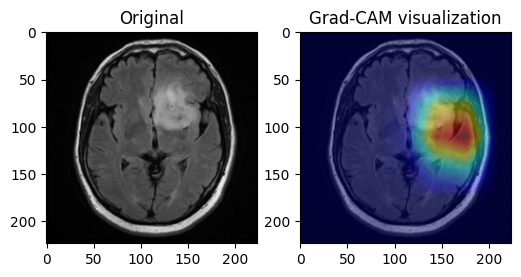

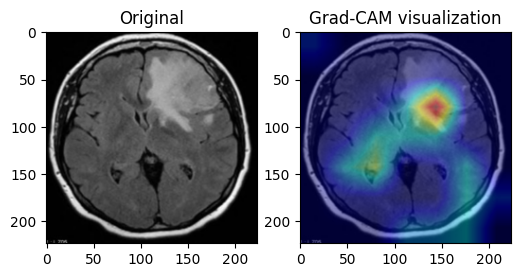

In [56]:
# Sample code of Pytorch-Grad-CAM
import torch
import torchvision
from torchvision.models import resnet50, ResNet50_Weights
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

from kernels import EdgeDetection, Blur, Sharpen, forward, tensor4plt, normalize_tensor, plot_tensors

resnet_model.eval()
target_layers = [resnet_model.layer4[-1]]

yes_test_dir = ".\\datasets\\brain_tumor\\test\\yes"
no_test_dir = ".\\datasets\\brain_tumor\\test\\no"

# Img paths
img_num = 2
paths = os.listdir(yes_test_dir)[:img_num]
paths = [os.path.join(yes_test_dir, p) for p in paths]

for i, path in enumerate(paths):
    img = torchvision.io.read_image(path)
    img = img.view(1, img.shape[0], img.shape[1], img.shape[2]).type(torch.float32) # from (C, H, W) to (1, C, H, W)
    img = v2.Resize((224, 224))(img)

    # Get grayscale
    img_tensor = v2.Grayscale(num_output_channels=3)(img)

    # We have to specify the target we want to generate the CAM for.
    targets = [ClassifierOutputTarget(1)]

    # Construct the CAM object once, and then re-use it on many images.
    with GradCAM(model=resnet_model, target_layers=target_layers) as cam:
        # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
        grayscale_cam = cam(input_tensor = img_tensor, targets = targets)

        # In this example grayscale_cam has only one image in the batch:
        grayscale_cam = grayscale_cam
        grayscale_cam = grayscale_cam[0, :]
        grayscale_cam = cv2.resize(grayscale_cam, (224, 224))
        
        model_outputs = cam.outputs

        import matplotlib.pyplot as plt
        from kernels.utils import tensor4plt

        # Normalize - min max scaling
        plot_img = tensor4plt(img)
        plot_img = (plot_img - plot_img.min()) / (plot_img.max() - plot_img.min())
        plot_img = np.array(plot_img)

        cam_heatmap_plot(plot_img, grayscale_cam)

        # visualization = show_cam_on_image(plot_img, grayscale_cam, use_rgb=False)

        # print("plot_img shape:", plot_img.shape)
        # print("grayscale_cam shape:", grayscale_cam.shape)
        # print("visualization shape:", visualization.shape)
        # plt.imshow(visualization)
        # plt.show()

## Kernels visualization


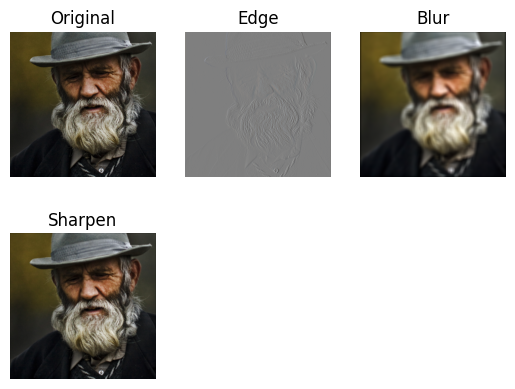

In [9]:
from kernels import EdgeDetection, Blur, Sharpen, forward, tensor4plt, normalize_tensor, plot_tensors

if __name__ == "__main__":
    import torchvision
    import torch

    # Đọc ảnh và chuẩn bị tensor
    path = "my_img.jpg"
    tensor_img = torchvision.io.read_image(path)
    tensor_img = tensor_img.view(1, tensor_img.shape[0], tensor_img.shape[1], tensor_img.shape[2]).type(torch.float32)

    # Áp dụng kernel
    images = [tensor_img,
              forward(tensor_img, EdgeDetection.sobel_x),
              forward(tensor_img, Blur.custom_mean_kernel(25)),
              forward(tensor_img, Sharpen.custom_sharpen(7, 25))]

    # Chuẩn hóa ảnh về khoảng [0, 1]
    for i in range(len(images)):    
        images[i] = normalize_tensor(images[i])

    # Plot ảnh
    plot_tensors(column = 3,
                 Original = images[0], Edge = images[1], Blur = images[2],
                 Sharpen = images[3])